In [1]:
%load_ext autoreload
%autoreload 2
%cd '/home/hew/python/genhance/'
%ls

/home/hew/python/genhance
ACE2/  data/  debug/  output/  temp/  tensorboard/  transformers_custom/


In [2]:
!nvidia-smi

Tue Apr 25 19:26:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   51C    P0    97W / 400W |  48962MiB / 81920MiB |     51%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  Off  | 00000000:00:06.0 Off |                    0 |
| N/A   

In [3]:
import re
import os
import torch
import numpy as np
import random
import scipy
import pandas as pd
import typing
import matplotlib.pyplot as plt
from transformers import T5Tokenizer
from transformers_custom import MT5ForConditionalGenerationWithLatentSpace
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from tqdm import tqdm

In [4]:
data_dir = "/home/hew/storage/storage/genhance/data"
# congen_name = 'congen2'
# congen_name = 'congen8_new_ddG_6_layer'
congen_name = 'congen9_new_solubility_6_layer'
# step_name = 42000
# pretrained_dir = f"/home/hew/storage/storage/genhance/ckpts/{congen_name}/results/step_{step_name}"
pretrained_dir = f"/home/hew/storage/storage/genhance/ckpts/{congen_name}/results/"
cache_dir = '/home/hew/storage/storage/genhance/pretrained/'

In [5]:
ckpt_args = torch.load(pretrained_dir + '/training_args.bin')
print('ckpt_args.property: ', ckpt_args.property)
ckpt_args.z_tar_vector_dim = 2 if ckpt_args.property == 'ddG_solubility' else 1
print('ckpt_args.z_tar_vector_dim: ', ckpt_args.z_tar_vector_dim)
print('ckpt_args.num_layers: ', ckpt_args.num_layers)
print('ckpt_args.num_decoder_layers: ', ckpt_args.num_decoder_layers)
ckpt_args

ckpt_args.property:  solubility
ckpt_args.z_tar_vector_dim:  1
ckpt_args.num_layers:  6
ckpt_args.num_decoder_layers:  6


Namespace(beta=1.0, beta_ratio_increase=0.25, beta_ratio_zero=0.25, beta_start_step=50000, cache_dir='/home/hew/storage/storage/genhance/pretrained/', contrastive_cyc_start_step=50000, contrastive_perturb_cyc_start_step=-1, cuda_device='0,1', data_dir='/home/hew/storage/storage/genhance/data/', datafile='train_new_tophalf_solubility.pkl', dim_target_kl=0.5, do_mi=False, eval_split_name='valid', eval_steps=500, lambda_contrastive=1.0, lambda_contrastive_cyc=1.0, lambda_contrastive_perturb_cyc=0.0, lambda_logvar_KL=0.0, lambda_logvar_L1=0.0, lambda_mi_head_loss=1.0, latent_pooler='cls', latent_size=1024, latent_space_type='wae', logging_dir='/home/hew/python/genhance/tensorboard/congen9_new_solubility_6_layer', logging_steps=20, lr=0.0001, mask_non_target_z_vector=False, mmd_method='rf', num_decoder_layers=6, num_layers=6, num_train_epochs=30, num_warmup_steps=0, output_dir='/home/hew/storage/storage/genhance/ckpts/congen9_new_solubility_6_layer/results/', pc_perturb=-0.25, pc_perturb_ty

In [6]:
np.random.seed(ckpt_args.seed)
random.seed(ckpt_args.seed)
torch.manual_seed(ckpt_args.seed)

tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", cache_dir=ckpt_args.cache_dir)
tokenizer.add_special_tokens({"cls_token": "<cls>"})
assert tokenizer.cls_token == "<cls>"

# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

In [7]:
%%time
latent_space_args = {
    'latent_pooler'                 : ckpt_args.latent_pooler,
    'pool_enc_hidden_states_for_dec': ckpt_args.pool_enc_hidden_states_for_dec,
    'latent_space_type'             : ckpt_args.latent_space_type,
    'mask_non_target_z_vector'      : ckpt_args.mask_non_target_z_vector,
    'separate_targetattr_head'      : ckpt_args.separate_targetattr_head,
    'z_tar_vector_dim'              : ckpt_args.z_tar_vector_dim,
    'do_mi'                         : ckpt_args.do_mi,
    'latent_size'                   : ckpt_args.latent_size,
    'wae_z_enc_type'                : ckpt_args.wae_z_enc_type,
    'separate_latent_enc'           : ckpt_args.separate_latent_enc,
    'separate_latent_dec'           : ckpt_args.separate_latent_dec,
    }

model = MT5ForConditionalGenerationWithLatentSpace.from_pretrained(pretrained_dir,
                                                                   cache_dir=ckpt_args.cache_dir,
                                                                   num_layers=ckpt_args.num_layers,
                                                                   num_decoder_layers=ckpt_args.num_decoder_layers,
                                                                   **latent_space_args)
model.parallelize()
model.resize_token_embeddings(len(tokenizer))

==================== T5 Model T5ForConditionalGenerationWithLatentSpace Initialization start ====================
========== Initialize T5ForConditionalGenerationWithLatentSpace ==========
latent_space_type:  wae
wae_z_enc_type:  deterministic
separate_latent_enc:  False
separate_latent_dec:  False
mmd_method:  rf
sigma_mmd:  None
rf_dim_mmd:  None
dim_target_kl:  0.5
latent_size:  1024
latent_pooler:  cls
pool_enc_hidden_states_for_dec:  True
mask_non_target_z_vector:  False
separate_targetattr_head:  False
do_mi:  False
========== Initialize T5ForConditionalGenerationWithLatentSpace ==========
==================== T5 Model T5ForConditionalGenerationWithLatentSpace Initialization end ====================
CPU times: user 25.5 s, sys: 4.61 s, total: 30.1 s
Wall time: 29 s


Embedding(129, 1024)

In [8]:
model.device

device(type='cuda', index=0)

# Evaluate Generator's ddG predictions

In [9]:
train_ratio = 0.9

# 80GB*1 6 layers
# per_device_train_batch_size = 1200
# per_device_eval_batch_size = 1200

# 80GB*2 24 layers
per_device_train_batch_size = 800
per_device_eval_batch_size = 800

In [10]:
class PKLDFDatasetForGen(Dataset):
    def __init__(
            self,
            data_file: typing.Union[str, Path],
            in_memory: bool = False,
            split: str = 'train',
            train_ratio: float = 1,
            data_subset='full'
            ):

        data_file = Path(data_file)
        if not data_file.exists():
            raise FileNotFoundError(data_file)

        df = pd.read_pickle(data_file)

        if train_ratio != 1:
            shuffled_df = df.sort_index()
            train_num_samples = int(len(shuffled_df)*train_ratio)
            if split == 'train':
                final_df = shuffled_df.iloc[:train_num_samples]
            elif split == 'valid':
                final_df = shuffled_df.iloc[train_num_samples:]
            else:
                final_df = df
        else:
            final_df = df

        # split into subset if not full training set
        if data_subset != 'full':
            ddG_sorted_final_df = final_df.sort_values(by='ddG', ascending=True)
            train_subset_num_samples = int(data_subset*len(ddG_sorted_final_df))
            final_df = ddG_sorted_final_df.iloc[:train_subset_num_samples]

        print("split: ", split)
        print("data_file: ", data_file)
        print("len(final_df): ", len(final_df))

        self.df = final_df
        num_examples = len(final_df)
        self._num_examples = num_examples

        if in_memory:
            cache = [None]*num_examples
            self._cache = cache

        self._in_memory = in_memory

    def __len__(self) -> int:
        return self._num_examples

    def __getitem__(self, index: int):
        if not 0 <= index < self._num_examples:
            raise IndexError(index)

        if self._in_memory and self._cache[index] is not None:
            item = self._cache[index]
        else:
            row = self.df.iloc[index]
            item = {}
            item['ddG'] = row['ddG']
            item['solubility'] = row['solubility']
            item['input_ids'] = row['MT_seq']
            item['labels'] = row['MT_seq']
            item['id'] = str(index)
            if self._in_memory:
                self._cache[index] = item

        return item


class CustomStabilityDatasetForGenLatentSpace(Dataset):
    def __init__(
            self,
            data_path: typing.Union[str, Path],
            split: str,
            tokenizer,
            in_memory: bool = False,
            train_ratio: float = 1,
            ):

        self.tokenizer = tokenizer

        if split == 'valid':
            file_prefix = 'train'
        else:
            file_prefix = split

        data_path = Path(data_path)
        # data_file = f'{file_prefix}_new_tophalf_ddG_solubility.pkl'  # tophalf
        data_file = f'{file_prefix}_new_tophalf_ddG.pkl'  # tophalf
        self.data = PKLDFDatasetForGen(data_path/data_file, in_memory, split, train_ratio, data_subset='full')

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int):
        item = self.data[index]
        input_ids = item['input_ids']
        labels = item['labels']
        if ckpt_args.property == 'ddG':
            ddG = item['ddG']
            solubility = None
        elif ckpt_args.property == 'solubility':
            ddG = None
            solubility = item['solubility']
        elif ckpt_args.property == 'ddG_solubility':
            ddG = item['ddG']
            solubility = item['solubility']
        return input_ids, labels, ddG, solubility

    def collate_fn(self, batch: typing.List[typing.Tuple[typing.Any, ...]]) -> typing.Dict[str, torch.Tensor]:
        input_ids, labels, ddG, solubility = tuple(zip(*batch))
        prefix = "<cls> "
        input_ids = [prefix + " ".join(list(re.sub(r"[UZOB]", "X", sequence))) for sequence in input_ids]
        labels = [prefix + " ".join(list(re.sub(r"[UZOB]", "X", sequence))) for sequence in labels]
        input_ids = self.tokenizer.batch_encode_plus(input_ids, add_special_tokens=True, padding="longest", return_tensors='pt')[
            'input_ids']
        labels = self.tokenizer.batch_encode_plus(labels, add_special_tokens=True, padding="longest", return_tensors='pt')['input_ids']
        ddG = torch.Tensor(ddG) if None not in ddG else None
        solubility = torch.Tensor(solubility) if None not in solubility else None
        return {
            'input_ids' : input_ids,
            'labels'    : labels,
            'ddG'       : ddG,
            'solubility': solubility
            }

In [11]:
train_dataset = CustomStabilityDatasetForGenLatentSpace(data_dir, 'train', train_ratio=train_ratio, tokenizer=tokenizer)
eval_dataset = CustomStabilityDatasetForGenLatentSpace(data_dir, 'valid', train_ratio=train_ratio, tokenizer=tokenizer)

# Train data set-up
train_loader = DataLoader(train_dataset, batch_size=per_device_train_batch_size, shuffle=True,
                          num_workers=0, collate_fn=train_dataset.collate_fn)
# Eval data set-up
eval_loader = DataLoader(eval_dataset, batch_size=per_device_eval_batch_size, shuffle=False,
                         num_workers=0, collate_fn=train_dataset.collate_fn)

split:  train
data_file:  /home/hew/storage/storage/genhance/data/train_new_tophalf_ddG.pkl
len(final_df):  112500
split:  valid
data_file:  /home/hew/storage/storage/genhance/data/train_new_tophalf_ddG.pkl
len(final_df):  12500


In [12]:
def spearmanr(target, prediction):
    target_array = np.asarray(target)
    prediction_array = np.asarray(prediction)
    print("target_array.shape: ", target_array.shape)
    print("prediction_array.shape: ", prediction_array.shape)
    return scipy.stats.spearmanr(target_array, prediction_array).correlation

In [13]:
def evaluate(model, eval_loader, do_mi=False, do_spearmanr=True, latent_space_type='wae', return_pred=False):
    eval_contrastive_loss_total = 0
    eval_lm_loss_total = 0
    if do_mi:
        eval_mi_head_loss_total = 0
    if latent_space_type in ['vae', 'wae']:
        eval_z_regu_loss_total = 0
    model.eval()
    num_eval_batch = 0

    ddG_preds = []
    ddG_targs = []
    solubility_preds = []
    solubility_targs = []

    with torch.no_grad():
        for step, batch in enumerate(tqdm(eval_loader)):
            input_ids = batch['input_ids'].to(model.device)
            labels = batch['labels'].to(model.device)
            ddG_targets = batch['ddG'].to(model.device) if batch['ddG'] is not None else None
            solubility_targets = batch['solubility'].to(model.device) if batch['solubility'] is not None else None
            contrast_targets = [ddG_targets, solubility_targets]

            if do_mi:
                model_outputs = model(input_ids, labels=labels, contrast_targets=contrast_targets)
                outputs, contrastive_loss, contrastive_value, mi_head_loss = model_outputs[0], model_outputs[1], model_outputs[2], \
                    model_outputs[3]
                eval_mi_head_loss_total = eval_mi_head_loss_total + mi_head_loss
            else:
                model_outputs = model(input_ids, labels=labels, contrast_targets=contrast_targets)
                outputs, contrastive_loss, contrastive_value = model_outputs[0], model_outputs[1], model_outputs[2]

            if latent_space_type in ['vae', 'wae']:
                z_regu_output = model_outputs[-1]
                if type(z_regu_output) is dict:
                    z_regu_loss = z_regu_output['z_regu_loss']
                else:
                    z_regu_loss = z_regu_output

            # contrastive_value: [batch_size, 1] or [batch_size, 2], ddG_targets: [batch_size]
            if ckpt_args.property == 'ddG':
                for pred, target in zip(contrastive_value.squeeze().cpu().numpy(), ddG_targets.cpu().numpy()):
                    ddG_targs.append(target)
                    ddG_preds.append(pred)
            elif ckpt_args.property == 'solubility':
                for pred, target in zip(contrastive_value.squeeze().cpu().numpy(), solubility_targets.cpu().numpy()):
                    solubility_targs.append(target)
                    solubility_preds.append(pred)
            elif ckpt_args.property == 'ddG_solubility':
                for pred, target in zip(contrastive_value[:, 0].squeeze().cpu().numpy(), ddG_targets.cpu().numpy()):
                    ddG_targs.append(target)
                    ddG_preds.append(pred)
                for pred, target in zip(contrastive_value[:, 1].squeeze().cpu().numpy(), solubility_targets.cpu().numpy()):
                    solubility_targs.append(target)
                    solubility_preds.append(pred)

            lm_loss = outputs.loss

            eval_contrastive_loss_total = eval_contrastive_loss_total + contrastive_loss
            eval_lm_loss_total = eval_lm_loss_total + lm_loss

            if latent_space_type in ['vae', 'wae']:
                eval_z_regu_loss_total = eval_z_regu_loss_total + z_regu_loss

            num_eval_batch += 1

    eval_lm_loss = eval_lm_loss_total/num_eval_batch
    eval_contrastive_loss = eval_contrastive_loss_total/num_eval_batch
    eval_output = {
        "lm_loss"         : eval_lm_loss,
        "contrastive_loss": eval_contrastive_loss,
        }

    if do_mi:
        eval_mi_head_loss_total = eval_mi_head_loss_total/num_eval_batch
        eval_output['mi_head_loss'] = eval_mi_head_loss_total

    if latent_space_type in ['vae', 'wae']:
        eval_z_regu_loss_total = eval_z_regu_loss_total/num_eval_batch
        eval_output['z_regu_loss'] = eval_z_regu_loss_total

    if do_spearmanr:
        ddG_spearmanr = 0
        solubility_spearmanr = 0
        if len(ddG_targs) > 0 and len(ddG_preds) > 0:
            ddG_spearmanr = spearmanr(ddG_targs, ddG_preds)
        if len(solubility_targs) > 0 and len(solubility_preds) > 0:
            solubility_spearmanr = spearmanr(solubility_targs, solubility_preds)

        print()
        print("========== evaluation finished ==========")
        print("ddG_spearmanr: ", ddG_spearmanr)
        print("solubility_spearmanr: ", solubility_spearmanr)
        print("========== evaluation finished ==========")
        eval_output['ddG_spearmanr'] = ddG_spearmanr
        eval_output['solubility_spearmanr'] = solubility_spearmanr

    if return_pred:
        eval_output['ddG_preds'] = ddG_preds
        eval_output['ddG_targs'] = ddG_targs
        eval_output['solubility_preds'] = solubility_preds
        eval_output['solubility_targs'] = solubility_targs

    return eval_output

In [14]:
eval_output = evaluate(model, eval_loader, do_mi=latent_space_args['do_mi'], return_pred=True,
                       latent_space_type=latent_space_args['latent_space_type'])

100%|██████████| 16/16 [00:43<00:00,  2.75s/it]


target_array.shape:  (12500,)
prediction_array.shape:  (12500,)

========== evaluation finished ==========
ddG_spearmanr:  0
solubility_spearmanr:  0.4666317936099932
========== evaluation finished ==========


In [15]:
eval_lm_loss, eval_contrastive_loss, eval_ddG_spearmanr, eval_solubility_spearmanr = eval_output['lm_loss'], eval_output[
    'contrastive_loss'], eval_output['ddG_spearmanr'], eval_output['solubility_spearmanr']

print("eval_lm_loss: ", eval_lm_loss)
print("eval_contrastive_loss: ", eval_contrastive_loss)
print("eval_ddG_spearmanr: ", eval_ddG_spearmanr)
print("eval_solubility_spearmanr: ", eval_solubility_spearmanr)

eval_lm_loss:  tensor(0.0030, device='cuda:0')
eval_contrastive_loss:  tensor(0.6350, device='cuda:1')
eval_ddG_spearmanr:  0
eval_solubility_spearmanr:  0.4666317936099932


In [16]:
ddG_preds, ddG_targs = eval_output['ddG_preds'], eval_output['ddG_targs']
solubility_preds, solubility_targs = eval_output['solubility_preds'], eval_output['solubility_targs']
print("len(ddG_preds): ", len(ddG_preds))
print("len(ddG_targs): ", len(ddG_targs))
print("len(solubility_preds): ", len(solubility_preds))
print("len(solubility_targs): ", len(solubility_targs))

len(ddG_preds):  0
len(ddG_targs):  0
len(solubility_preds):  12500
len(solubility_targs):  12500


In [17]:
if 'ddG' in ckpt_args.property:
    print("stats of ddG_preds")
    print("min: ", np.min(ddG_preds))
    print("mean: ", np.mean(ddG_preds))
    print("median: ", np.median(ddG_preds))
    print("max: ", np.max(ddG_preds))
    print("std: ", np.std(ddG_preds))
    print("25% std: ", 0.25*np.std(ddG_preds))
if 'solubility' in ckpt_args.property:
    print("stats of solubility_preds")
    print("min: ", np.min(solubility_preds))
    print("mean: ", np.mean(solubility_preds))
    print("median: ", np.median(solubility_preds))
    print("max: ", np.max(solubility_preds))
    print("std: ", np.std(solubility_preds))
    print("25% std: ", 0.25*np.std(solubility_preds))

stats of solubility_preds
min:  -2.449766
mean:  -1.1901786
median:  -2.3222866
max:  10.4042425
std:  1.9524919
25% std:  0.48812296986579895


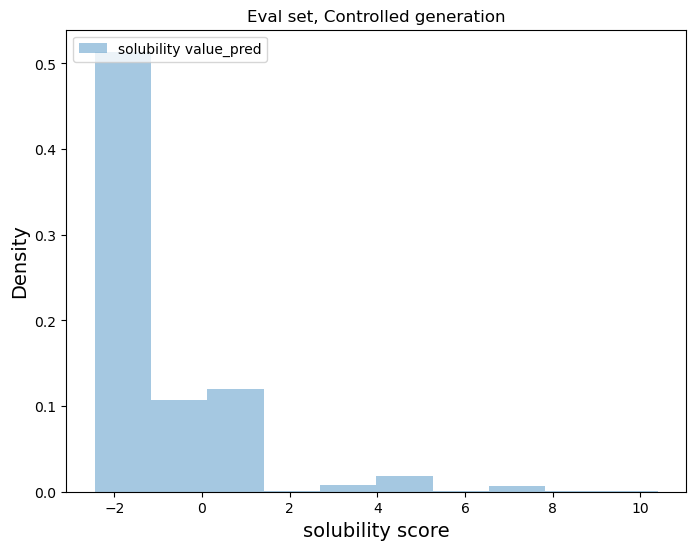

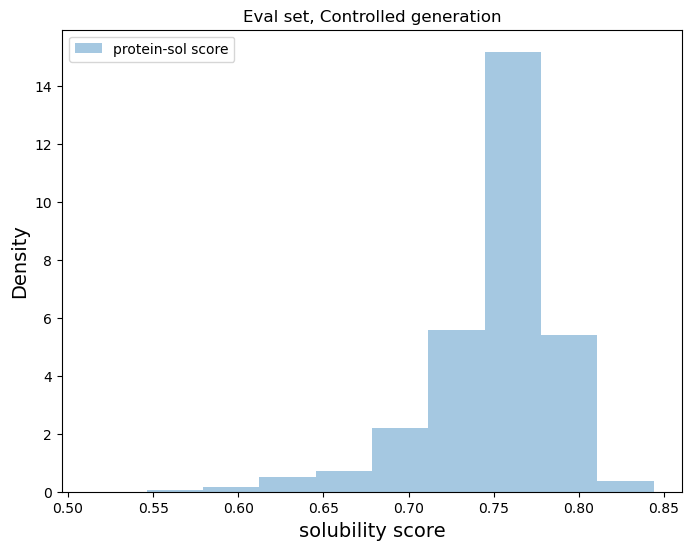

In [18]:
if 'ddG' in ckpt_args.property:
    plt.figure(figsize=(8, 6))
    plt.hist(ddG_preds, density=True, label='ddG value_pred', bins=[i for i in range(-20, 10)], alpha=0.4)
    plt.hist(ddG_targs, density=True, label='foldx ddG', bins=[i for i in range(-20, 10)], alpha=0.4)
    plt.xlabel("ddG", size=14)
    plt.ylabel("Density", size=14)
    plt.title("Eval set, Controlled generation")
    plt.legend(loc='upper left')
if 'solubility' in ckpt_args.property:
    plt.figure(figsize=(8, 6))
    plt.hist(solubility_preds, density=True, label='solubility value_pred', alpha=0.4)
    plt.xlabel("solubility score", size=14)
    plt.ylabel("Density", size=14)
    plt.title("Eval set, Controlled generation")
    plt.legend(loc='upper left')

    plt.figure(figsize=(8, 6))
    plt.hist(solubility_targs, density=True, label='protein-sol score', alpha=0.4)
    plt.xlabel("solubility score", size=14)
    plt.ylabel("Density", size=14)
    plt.title("Eval set, Controlled generation")
    plt.legend(loc='upper left')

In [20]:
eval_df = pd.DataFrame()
eval_df['value_pred'] = ddG_preds
eval_df['ddG'] = ddG_targs
eval_df = eval_df.sort_values(by='value_pred', ascending=True)
eval_df

,value_pred,ddG
762,-14.139789,-4.58069
10550,-13.925159,-4.23669
3274,-13.829757,-4.86664
5230,-13.809940,-4.75198
8602,-13.746979,-5.00012
...,...,...
725,10.009272,4.71477
11910,10.137735,4.61548
6653,10.420370,4.81421
11572,10.513784,4.61348


In [24]:
# topK_list = [10, 100, 1000, 10000]
percentile_list = [95, 90, 85, 80, 75]
topK_list = [len(eval_df)*(100 - i)//100 for i in percentile_list]
print(topK_list)

[625, 1250, 1875, 2500, 3125]


In [25]:
ddG_df = eval_df
all_ddG_list = eval_df['ddG']

In [26]:
for topK in topK_list:
    topK_df = ddG_df[:topK]
    print("top K: ", len(topK_df))
    print("max: ", np.max(topK_df['ddG']))
    print("min: ", np.min(topK_df['ddG']))
    print("mean: ", np.mean(topK_df['ddG']))
    print("median: ", np.median(topK_df['ddG']))
    
    for percentile in percentile_list:
        pct = np.percentile(all_ddG_list, 100 - percentile)
        PCI_pct = np.sum(topK_df['ddG'] < pct)/len(topK_df['ddG'])
        print("PCI_{}pct: ".format(percentile), PCI_pct)
    
    PCI_WT = np.sum(topK_df['ddG'] < 0)/len(topK_df['ddG'])
    print("PCI_WT: ", PCI_WT)
    
    print("_"*20)

tophalf_df = ddG_df[:len(ddG_df)//2]
print("top half: ", len(tophalf_df))
print("max: ", np.max(tophalf_df['ddG']))
print("min: ", np.min(tophalf_df['ddG']))
print("mean: ", np.mean(tophalf_df['ddG']))
print("median: ", np.median(tophalf_df['ddG']))

# PCI_75pct = np.sum(tophalf_df['ddG'] < train_75pct) / len(tophalf_df['ddG'])
# print("PCI_75pct: ", PCI_75pct)

for percentile in percentile_list:
    pct = np.percentile(all_ddG_list, 100 - percentile)
    PCI_pct = np.sum(tophalf_df['ddG'] < pct)/len(tophalf_df['ddG'])
    print("PCI_{}pct: ".format(percentile), PCI_pct)

PCI_WT = np.sum(tophalf_df['ddG'] < 0)/len(tophalf_df['ddG'])
print("PCI_WT: ", PCI_WT)

print("_"*20)

# training data distribution
print("train dataset: ", len(all_ddG_list))
print("max: ", np.max(all_ddG_list))
print("min: ", np.min(all_ddG_list))
print("mean: ", np.mean(all_ddG_list))
print("median: ", np.median(all_ddG_list))

for percentile in percentile_list:
    pct = np.percentile(all_ddG_list, 100 - percentile)
    PCI_pct = np.sum(all_ddG_list < pct)/len(all_ddG_list)
    print("PCI_{}pct: ".format(percentile), PCI_pct)

PCI_WT = np.sum(all_ddG_list < 0)/len(all_ddG_list)
print("PCI_WT: ", PCI_WT)

print("_"*20)

top K:  625
max:  -0.03659899905323982
min:  -5.416450023651123
mean:  -1.8593817
median:  -1.67805
PCI_95pct:  0.8672
PCI_90pct:  0.9952
PCI_85pct:  0.9968
PCI_80pct:  1.0
PCI_75pct:  1.0
PCI_WT:  1.0
____________________
top K:  1250
max:  0.3907800018787384
min:  -5.416450023651123
mean:  -1.3627449
median:  -1.18961
PCI_95pct:  0.4864
PCI_90pct:  0.884
PCI_85pct:  0.9824
PCI_80pct:  0.9968
PCI_75pct:  0.9976
PCI_WT:  0.9976
____________________
top K:  1875
max:  1.0369499921798706
min:  -5.416450023651123
mean:  -1.0596857
median:  -0.895829
PCI_95pct:  0.33013333333333333
PCI_90pct:  0.6565333333333333
PCI_85pct:  0.9045333333333333
PCI_80pct:  0.9808
PCI_75pct:  0.9925333333333334
PCI_WT:  0.9813333333333333
____________________
top K:  2500
max:  2.750420093536377
min:  -5.416450023651123
mean:  -0.8265798
median:  -0.651613
PCI_95pct:  0.2488
PCI_90pct:  0.4964
PCI_85pct:  0.7312
PCI_80pct:  0.9124
PCI_75pct:  0.978
PCI_WT:  0.9208
____________________
top K:  3125
max:  2.750

# Get value_pred of gen input samples

In [27]:
input_data_path = Path(data_dir)
input_data_file = f'train_new_tophalf_ddG_solubility.pkl'
input_data_file = input_data_path/input_data_file
input_data_df = pd.read_pickle(input_data_file)
input_data_df

,PDB,Chain,Start_index,WT_seq,MT_seq,ddG,R_label,solubility
126123,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEKEDLFYQSSLAIWNYNTNITEENVQNMNF...,-6.59818,5,0.764
84432,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,SYIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-6.00327,5,0.764
152024,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,SDIEEQAKSFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-5.98875,5,0.781
8286,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,SDIEEQAKTFLKKFNHEAQDLFYQSSLASWNYNTNITEENVQNMNN...,-5.91251,5,0.713
117039,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-5.89473,5,0.713
...,...,...,...,...,...,...,...,...
194795,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLPKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,3.57494,0,0.713
239399,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAVDLFSQSSLASWNYNTNITEENVQNMNN...,3.57505,0,0.713
43578,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAYDLFYQSSLASNNYNTNITEENVQNMNN...,3.57507,0,0.701
33515,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEYQAKTFLDKFNEEAEDLFLQSSLASWNYNTNITEENVKNMNN...,3.57508,0,0.764


In [28]:
topk_as_input = 12500

In [29]:
print("ddG stats of input data")
print("min: ", np.min(input_data_df['ddG']))
print("mean: ", np.mean(input_data_df['ddG']))
print("median: ", np.median(input_data_df['ddG']))
print("max: ", np.max(input_data_df['ddG']))
print("std: ", np.std(input_data_df['ddG']))

ddG_sorted_input_df = input_data_df.sort_values(by='ddG', ascending=True)
gen_input_df = ddG_sorted_input_df.iloc[:topk_as_input]

ddG stats of input data
min:  -6.59818
mean:  1.26221709496
median:  1.3439199999999998
max:  3.5751
std:  1.42693826641798


In [30]:
gen_input_df

,PDB,Chain,Start_index,WT_seq,MT_seq,ddG,R_label,solubility
126123,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEKEDLFYQSSLAIWNYNTNITEENVQNMNF...,-6.598180,5,0.764
84432,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,SYIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-6.003270,5,0.764
152024,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,SDIEEQAKSFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-5.988750,5,0.781
8286,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,SDIEEQAKTFLKKFNHEAQDLFYQSSLASWNYNTNITEENVQNMNN...,-5.912510,5,0.713
117039,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-5.894730,5,0.713
...,...,...,...,...,...,...,...,...
155099,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STWEEQAKLFLDKFNHEAEDLFYQSSLASWNYNTNITEENKQNMNN...,-0.628241,1,0.781
108721,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,SNIEEQAKTFLDKFEHEAEDLFYQSSLASWNMNTNITEENVQNMNN...,-0.628223,1,0.781
224553,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNIEAEDLFYQSSLASWNYNTNITEENVQNMNR...,-0.628191,1,0.764
87017,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEYAKTFLDKFNHTAEDLFYQSSLASWNYNTNITEENVQNMQN...,-0.628175,1,0.764


# Get value_pred of train data

In [31]:
train_eval_output = evaluate(model, train_loader, do_mi=latent_space_args['do_mi'], return_pred=True,
                             latent_space_type=latent_space_args['latent_space_type'])
# eval_output = evaluate(model, eval_loader, do_mi=latent_space_args['do_mi'], return_pred=True, latent_space_type=latent_space_args['latent_space_type'])

100%|██████████| 94/94 [04:00<00:00,  2.56s/it]

target_array.shape:  (112500,)
prediction_array.shape:  (112500,)

========== evaluation finished ==========
ddG_spearmanr:  0.987740779671342
solubility_spearmanr:  0
========== evaluation finished ==========


In [32]:
train_lm_loss, train_contrastive_loss, train_eval_ddG_spearmanr, train_eval_solubility_spearmanr = eval_output['lm_loss'], \
    train_eval_output['contrastive_loss'], train_eval_output['ddG_spearmanr'], train_eval_output['solubility_spearmanr']
print("train_lm_loss: ", train_lm_loss)
print("train_contrastive_loss: ", train_contrastive_loss)
print("train_eval_ddG_spearmanr: ", train_eval_ddG_spearmanr)
print("train_eval_solubility_spearmanr: ", train_eval_solubility_spearmanr)

train_lm_loss:  tensor(0.0967, device='cuda:0')
train_contrastive_loss:  tensor(0.1809, device='cuda:0')
train_eval_ddG_spearmanr:  0.987740779671342
train_eval_solubility_spearmanr:  0


In [33]:
train_ddG_preds, train_ddG_targs = train_eval_output['ddG_preds'], train_eval_output['ddG_targs']
print("len(train_ddG_preds): ", len(train_ddG_preds))
print("len(train_ddG_targs): ", len(train_ddG_targs))

len(train_ddG_preds):  112500
len(train_ddG_targs):  112500


In [34]:
print("stats of ddG_preds, train set")
print("min: ", np.min(train_ddG_preds))
print("mean: ", np.mean(train_ddG_preds))
print("median: ", np.median(train_ddG_preds))
print("max: ", np.max(train_ddG_preds))
print("std: ", np.std(train_ddG_preds))
print("25% std: ", 0.25*np.std(train_ddG_preds))

stats of ddG_preds, train set
min:  -4.792978
mean:  1.763174
median:  1.387753
max:  9.144854
std:  2.6748562
25% std:  0.6687140464782715


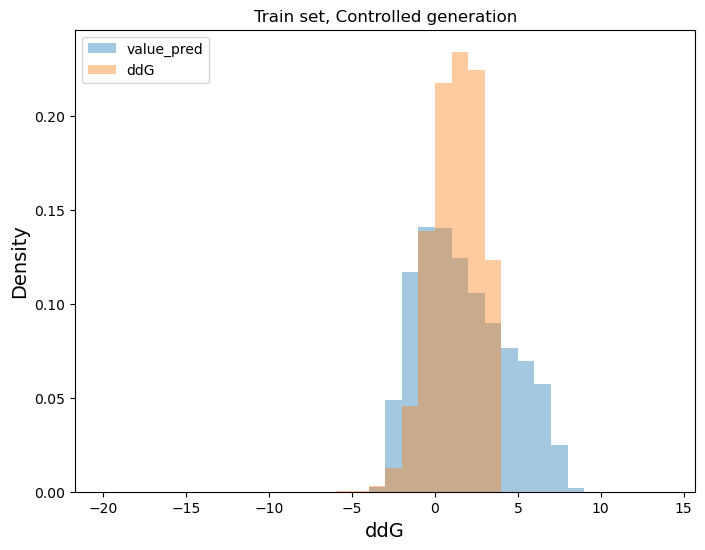

In [35]:
plt.figure(figsize=(8, 6))
plt.hist(train_ddG_preds, density=True, label='value_pred', bins=[i for i in range(-20, 15)], alpha=0.4)

plt.hist(train_ddG_targs, density=True, label='ddG', bins=[i for i in range(-20, 15)], alpha=0.4)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
plt.title("Train set, Controlled generation")
plt.legend(loc='upper left')

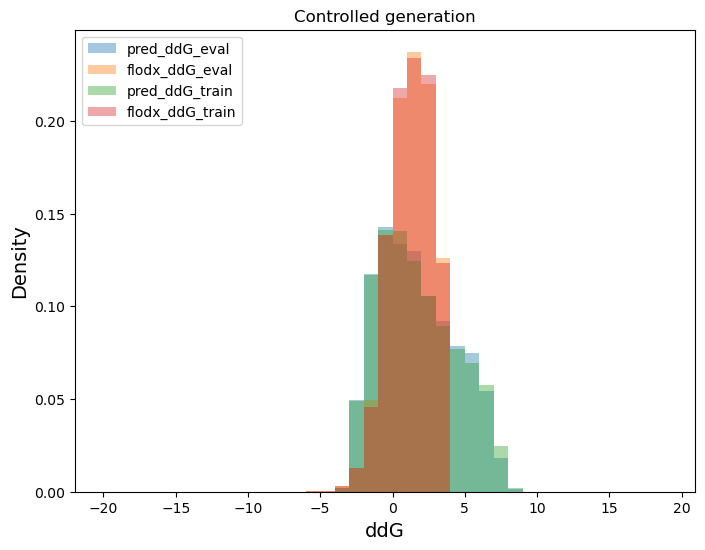

In [36]:
plt.figure(figsize=(8, 6))

plt.hist(ddG_preds, density=True, label='pred_ddG_eval', bins=[i for i in range(-20, 20)], alpha=0.4)

plt.hist(ddG_targs, density=True, label='flodx_ddG_eval', bins=[i for i in range(-20, 20)], alpha=0.4)

plt.hist(train_ddG_preds, density=True, label='pred_ddG_train', bins=[i for i in range(-20, 20)], alpha=0.4)

plt.hist(train_ddG_targs, density=True, label='flodx_ddG_train', bins=[i for i in range(-20, 20)], alpha=0.4)

plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
plt.title("Controlled generation")
plt.legend(loc='upper left')

In [37]:
np.std(ddG_preds)*0.25, np.std(train_ddG_preds)*0.25

(0.6580755114555359, 0.6687140464782715)

In [38]:
min(min(ddG_preds), min(train_ddG_preds))

-4.792978

## save data for checking

In [39]:
pred_data = (train_ddG_preds, train_ddG_targs, ddG_preds, ddG_targs)
path = f'/home/hew/python/genhance/output/{congen_name}_step{step_name}_pred_data.npy'
np.save(path, pred_data)

/home/hew/miniconda3/envs/genhance/lib/python3.8/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


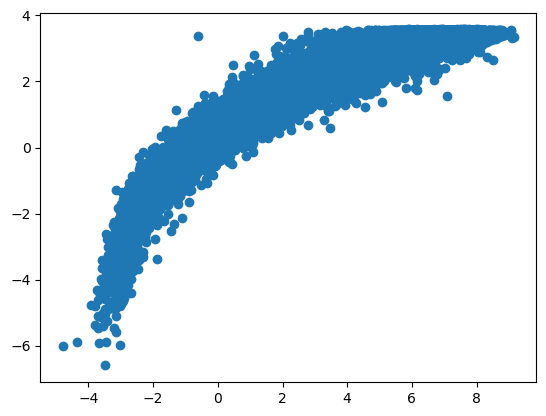

In [40]:
plt.scatter(train_ddG_preds, train_ddG_targs)

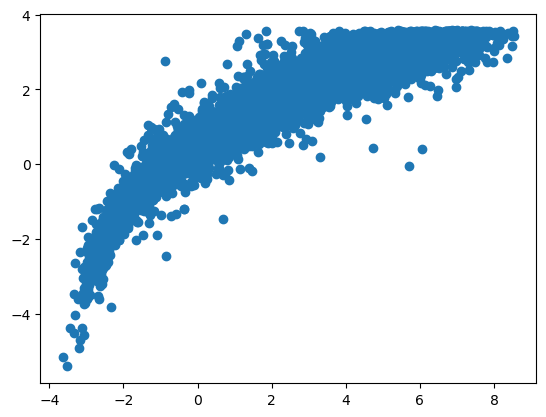

In [41]:
plt.scatter(ddG_preds, ddG_targs)

In [42]:
len(ddG_preds), len(train_ddG_preds)

(12500, 112500)

In [43]:
train_ddG_preds, train_ddG_targs, ddG_preds, ddG_targs = np.load(path, allow_pickle=True)